In [1]:
import matplotlib.pyplot as plt
from itertools import combinations
from random import random,randint
import numpy as np
from functools import reduce
from scipy.optimize import minimize
from scipy.linalg import expm,sinm,cosm

import time
import math
from   matplotlib import cm
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.quantum_info.analysis import average_data
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.utils import tensorproduct
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram
import picos as pic
import warnings
from docplex.mp.model import Model
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import CplexOptimizer
import scipy.linalg as la

In [2]:
# Evaluate the function
step_size   = 0.01;

# We import plotting tools 

import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nic

a_gamma         = np.arange(0, 2*np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 1/32*np.sin(4*a_gamma)*np.sin(2*a_beta)*(4*(np.cos(4*a_gamma)+np.cos(12*a_gamma)+np.cos(20*a_gamma)+np.cos(24*a_gamma)))*((np.sin(2*a_beta))**4)+5*(np.cos(4*a_gamma)+np.cos(12*a_gamma))*(25+36*np.cos(4*a_beta)+3*np.cos(8*a_beta))

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(-100,640)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 640.000
This is attained for gamma = 0.000 and beta = 0.000


[[0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]
 [0.25]]
Numbers of iteration:  3969

 Average expectation using QAOA with fine grid :  [[3.22129004e-07]]

 Maximum expectation using QAOA with fine grid :  [[1.78917254]]

 Optimal gamma :  3.0

 Optimal beta :  2.8000000000000003

 Runningtime :  4.994309902191162


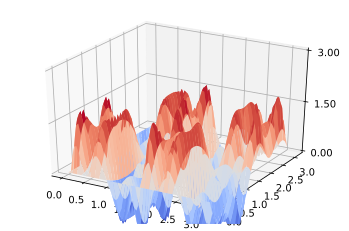

In [10]:
s = init_s(n)
s_d = (s).T
print(s)

#run the program
start_time = time.time()
step_size   = 0.05
result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
print("Numbers of iteration: ",(pow((int(3.14/step_size)+1),2)))
f_p_max = 0
f_p_max_gamma = 0
f_p_max_beta = 0
f_psum = 0

for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
    for j in range(0, int(3.14/step_size)+1):       # j for a_beta
        
        #Construct U_C
        U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
        #Construct U_B
        U_B = expm(-1j*a_beta[j]*B)


        #Construct expection of each subgraph
        state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
        state_d = (state.conjugate()).T # bra
    
        
        f_p = (state_d.dot(C)).dot(state)
        f_psum += f_p
        
            
        if f_p.real > f_p_max:
            f_p_max = f_p.real
            f_p_max_gamma = a_gamma[i]
            f_p_max_beta = a_beta[j]
            
        result_array[i][j] = f_p.real
print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
print("\n Optimal gamma : ",f_p_max_gamma)
print("\n Optimal beta : ",f_p_max_beta)


end_time = time.time()
print("\n Runningtime : ",end_time - start_time)






# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

gamma = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
beta = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))

for i in range(0, int(3.14/step_size)+1):
    for j in range(0, int(3.14/step_size)+1):
        gamma[i][j] = a_gamma[i]
        beta[i][j] = a_beta[j]



surf = ax.plot_surface(gamma, beta, result_array, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(0, np.ceil(f_p_max)+1)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

In [3]:
def num_1_pos(d):
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    num_1 = get_indexes(1,d)
    return num_1,len(num_1)

def num_0_pos(d):
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    num_0 = get_indexes(0,d)
    return num_0,len(num_0)

def column(matrix, i):
    return [row[i] for row in matrix]

#Construct initial state 
def init_s(n):
    x = pow(2,n)
    s = 1/np.sqrt(x) * np.ones(x)
    s = s.reshape(x, 1)
    return s

def bin2dec(string_num):
    return str(int(string_num, 2))

def row_binary(v):
    for i in range(len(v)):
        if v[i]%2 == 0:
            v[i] = 0
        else:
            v[i] = 1 
    return v

def converter(d):
    P = 0
    for i in range(len(d)):
        P+=d[i]*(2**(len(d)-i-1))
    return P
                 
#Define some pauli operators
PauliX = [[0,1],[1,0]]   
PauliZ = [[1,0],[0,-1]]
PauliI = np.eye(2)

#Define Cjk and B
def Cjk_generator(d):
    n = len(d)
    l = list(range(0,n))    
    for i in range(n):
        l[i] = PauliI
    s = num_1_pos(d)[0]
    for j in range(len(s)):
        l[s[j]] = PauliZ
    Cjk = l[0]
    for i in range(n-1):
        Cjk = np.kron(Cjk,l[i+1])
    return Cjk

def B_generator(n):
    l = list(range(0,n))
    b = list(range(0,n))
    
    for a in range(n):
        for i in range(n):
            l[i] = PauliI
        l[a]=PauliX
        temp = l[0]
        for i in range(n-1):
            temp = np.kron(temp,l[i+1])
        b[a] = temp
    B = sum(b[a] for a in range(n))
    return B

def basis(n):
    nums = np.array([a for a in range(2**(n))]) 
    bin_nums = (((nums.reshape(-1,1) & (2**np.arange(n)))) != 0).astype(int)
    a = bin_nums[:,::-1]
    return a


def matrix_binary(A):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i][j]%2 == 0:
                A[i][j] = 0
            else:
                A[i][j] = 1
    return A

def error(n,err):
    e = np.zeros(n)
    a = np.random.randint(n,size=err)
    for i in range(len(a)):
        e[a[i]] = 1 
    return e

print(error(16,2))
    




[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]


# Oringinal Generator matrix without error

In [10]:
G_oringin = np.array([[1,0,0,0,1,1,0],
              [0,1,0,0,1,0,1],
              [0,0,1,0,0,1,1],
              [0,0,0,1,1,1,1]])
G_oringinT = G_oringin.T

n = G_oringin.shape[0]
u=0

for k in range(2**n):
    print("$$$$$$$$$$$$$$$$$$$")
    message = basis(n)[k]
    y = row_binary(message.dot(G_oringin))
    print("y = ",y)
    C = sum((1-2*y[a])*Cjk_generator(G_oringinT[a]) for a in range(G_oringinT.shape[0]))
    B = B_generator(G_oringinT.shape[1])
    s = init_s(n)
    s_d = (s).T
    print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.05
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)
    print("Numbers of iteration: ",(pow((int(3.14/step_size)+1),2)))
    f_p_max = 0
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0

    for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for j in range(0, int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)


            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p


            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
    print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
    print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
    print("\n Optimal gamma : ",f_p_max_gamma)
    print("\n Optimal beta : ",f_p_max_beta)


    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time)
    c = converter(message)
    r = np.ones(2**len(message))
    print(r)
    #Construct U_C
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)


    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    print(state)
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))
    print(prob)      
    e = np.max(prob)
    print(e)
    print("most likey basis:  ",int(np.where(prob==np.max(prob))[0])+1)
    if int(k+1) != int(np.where(prob==np.max(prob))[0]+1):
        print("CANNOT correct！！！！！！")
    else:
        print("Good Job!!!!!!")
        u+=1

print("---------------")
print('correct rate: ',u/16*100,'%')



$$$$$$$$$$$$$$$$$$$
y =  [0 0 0 0 0 0 0]
the number of basis 1
Numbers of iteration:  3969

 Average expectation using QAOA with fine grid :  [[3.22129004e-07]]

 Maximum expectation using QAOA with fine grid :  [[1.78917254]]

 Optimal gamma :  3.0

 Optimal beta :  2.8000000000000003

 Runningtime :  4.7673492431640625
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[-1.0706127 +1.6510002j ]
 [-0.35894402+0.39051372j]
 [-0.00617266+0.82392397j]
 [ 0.64231427+1.15688249j]
 [-0.00617266+0.82392397j]
 [ 0.64231427+1.15688249j]
 [ 0.28954291+0.72347223j]
 [ 0.39601114+0.39051372j]
 [-0.00617266+0.82392397j]
 [ 0.64231427+1.15688249j]
 [ 0.28954291+0.72347223j]
 [ 0.39601114+0.39051372j]
 [ 0.28954291+0.72347223j]
 [ 0.39601114+0.39051372j]
 [ 0.7487825 +0.82392397j]
 [-0.71784133+0.22935452j]]
[3.8720132058653842, 0.2813417741617564, 0.6788888082180752, 1.750944710841615, 0.6788888082180746, 1.750944710841614, 0.607247168526339, 0.30932578181789316, 0.6788888082180751, 1.7509447108416


 Average expectation using QAOA with fine grid :  [[3.22129004e-07]]

 Maximum expectation using QAOA with fine grid :  [[1.78917254]]

 Optimal gamma :  3.0

 Optimal beta :  2.8000000000000003

 Runningtime :  4.898427963256836
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 0.39601114+0.39051372j]
 [ 0.28954291+0.72347223j]
 [ 0.64231427+1.15688249j]
 [-0.00617266+0.82392397j]
 [ 0.64231427+1.15688249j]
 [-0.00617266+0.82392397j]
 [-0.35894402+0.39051372j]
 [-1.0706127 +1.6510002j ]
 [-0.71784133+0.22935452j]
 [ 0.7487825 +0.82392397j]
 [ 0.39601114+0.39051372j]
 [ 0.28954291+0.72347223j]
 [ 0.39601114+0.39051372j]
 [ 0.28954291+0.72347223j]
 [ 0.64231427+1.15688249j]
 [-0.00617266+0.82392397j]]
[0.3093257818178933, 0.6072471685263386, 1.750944710841614, 0.6788888082180753, 1.7509447108416143, 0.6788888082180752, 0.2813417741617563, 3.8720132058653824, 0.5678996736926614, 1.2395259380684336, 0.30932578181789316, 0.6072471685263385, 0.3093257818178933, 0.6072471685263389, 1.750


 Average expectation using QAOA with fine grid :  [[3.22129004e-07]]

 Maximum expectation using QAOA with fine grid :  [[1.78917254]]

 Optimal gamma :  3.0

 Optimal beta :  2.8000000000000003

 Runningtime :  5.52453088760376
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 0.7487825 +0.82392397j]
 [-0.71784133+0.22935452j]
 [ 0.28954291+0.72347223j]
 [ 0.39601114+0.39051372j]
 [ 0.28954291+0.72347223j]
 [ 0.39601114+0.39051372j]
 [-0.00617266+0.82392397j]
 [ 0.64231427+1.15688249j]
 [ 0.28954291+0.72347223j]
 [ 0.39601114+0.39051372j]
 [-0.00617266+0.82392397j]
 [ 0.64231427+1.15688249j]
 [-0.00617266+0.82392397j]
 [ 0.64231427+1.15688249j]
 [-1.0706127 +1.6510002j ]
 [-0.35894402+0.39051372j]]
[1.2395259380684334, 0.5678996736926614, 0.6072471685263388, 0.30932578181789316, 0.6072471685263388, 0.30932578181789294, 0.6788888082180748, 1.7509447108416143, 0.6072471685263389, 0.3093257818178929, 0.6788888082180752, 1.7509447108416145, 0.6788888082180748, 1.7509447108416145, 3.87

# Oringinal with one bit error

In [5]:
G_oringin = np.array([[1,0,0,0,1,1,0],
              [0,1,0,0,1,0,1],
              [0,0,1,0,0,1,1],
              [0,0,0,1,1,1,1]])
G_oringinT = G_oringin.T

n = G_oringin.shape[0]
u=0

for k in range(2**n):
    print("$$$$$$$$$$$$$$$$$$$")
    message = basis(n)[k]
    w = error(G_oringin.shape[1],1) 
    print("w = ",w)
    y = row_binary(message.dot(G_oringin)+w)
    print("y = ",y)
    C = sum((1-2*y[a])*Cjk_generator(G_oringinT[a]) for a in range(G_oringinT.shape[0]))
    B = B_generator(G_oringinT.shape[1])
    s = init_s(n)
    s_d = (s).T
    print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.05
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)
    print("Numbers of iteration: ",(pow((int(3.14/step_size)+1),2)))
    f_p_max = 0
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0

    for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for j in range(0, int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)


            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p


            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
    print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
    print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
    print("\n Optimal gamma : ",f_p_max_gamma)
    print("\n Optimal beta : ",f_p_max_beta)


    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time)
    c = converter(message)
    r = np.ones(2**len(message))
    print(r)
    #Construct U_C
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)


    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    print(state)
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))
    print(prob)      
    e = np.max(prob)
    print(e)
    print("most likey basis:  ",int(np.where(prob==np.max(prob))[0])+1)
    if int(k+1) != int(np.where(prob==np.max(prob))[0]+1):
        print("CANNOT correct！！！！！！")
    else:
        print("Good Job!!!!!!")
        u+=1

print("---------------")
print('correct rate: ',u/16*100,'%')




$$$$$$$$$$$$$$$$$$$
w =  [0. 1. 0. 0. 0. 0. 0.]
y =  [0. 1. 0. 0. 0. 0. 0.]
the number of basis 1
Numbers of iteration:  3969

 Average expectation using QAOA with fine grid :  [[3.22128807e-07]]

 Maximum expectation using QAOA with fine grid :  [[2.11627636]]

 Optimal gamma :  0.9500000000000001

 Optimal beta :  2.35

 Runningtime :  4.689960956573486
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[-1.53894246-0.00726639j]
 [-0.93575372+0.01183333j]
 [-0.59688533-0.00671233j]
 [ 0.63181088-0.01805876j]
 [ 0.95670121-0.00181119j]
 [ 2.18539742-0.01315762j]
 [-0.46947568+0.00538803j]
 [-1.07238326+0.01673446j]
 [-0.59688533-0.00671233j]
 [ 0.63181088-0.01805876j]
 [ 0.29294249+0.00048689j]
 [-0.30996509+0.01183333j]
 [-0.46947568+0.00538803j]
 [-1.07238326+0.01673446j]
 [ 1.58248984-0.00181119j]
 [ 0.35351248-0.00540434j]]
[2.3683966806913204, 0.8757750598679864, 0.356317149958989, 0.39951110948170576, 0.9152804827098504, 4.776134999760433, 0.2204364460731883, 1.1502858907204687,


 Average expectation using QAOA with fine grid :  [[3.21567388e-07]]

 Maximum expectation using QAOA with fine grid :  [[2.27776252]]

 Optimal gamma :  1.4000000000000001

 Optimal beta :  2.8000000000000003

 Runningtime :  4.957321882247925
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 0.02019113+0.10784973j]
 [-0.70199296-0.97534489j]
 [-0.60707221-1.37833726j]
 [ 0.43406166-0.29514265j]
 [-0.27905928-0.45573413j]
 [ 0.10604872-1.21774578j]
 [ 0.01112797-0.81475341j]
 [ 1.12791322-1.48382077j]
 [ 0.04895366+0.05274176j]
 [-0.7307555 -0.29514265j]
 [ 0.02019113+0.10784973j]
 [-0.70199296-0.97534489j]
 [-1.15368918-0.81475341j]
 [ 0.47188735-0.05274176j]
 [-0.27905928-0.45573413j]
 [ 0.10604872-1.21774578j]]
[0.012039244811770567, 1.4440917712230932, 2.268350278955861, 0.27551870500927456, 0.2855676772359419, 1.4941511169682873, 0.6639469451054898, 3.4739123112221373, 0.005178153468310458, 0.6211127799649652, 0.012039244811770742, 1.444091771223094, 1.9948218465316914, 0.225


 Average expectation using QAOA with fine grid :  [[3.22128807e-07]]

 Maximum expectation using QAOA with fine grid :  [[2.11627636]]

 Optimal gamma :  0.9500000000000001

 Optimal beta :  2.35

 Runningtime :  6.265535116195679
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 1.58248984-0.00181119j]
 [ 0.35351248-0.00540434j]
 [-0.46947568+0.00538803j]
 [-1.07238326+0.01673446j]
 [-0.46947568+0.00538803j]
 [-1.07238326+0.01673446j]
 [ 0.95670121-0.00181119j]
 [ 2.18539742-0.01315762j]
 [ 0.29294249+0.00048689j]
 [-0.30996509+0.01183333j]
 [-0.59688533-0.00671233j]
 [ 0.63181088-0.01805876j]
 [-0.59688533-0.00671233j]
 [ 0.63181088-0.01805876j]
 [-1.53894246-0.00726639j]
 [-0.93575372+0.01183333j]]
[2.50427738457712, 0.12500027862922428, 0.22043644607318902, 1.1502858907204676, 0.22043644607318844, 1.1502858907204687, 0.9152804827098496, 4.776134999760435, 0.0858155370901605, 0.09621838420520712, 0.3563171499589891, 0.39951110948170604, 0.35631714995898967, 0.39951110948170604, 

# Oringinal with two bit error

In [4]:
G_oringin = np.array([[1,0,0,0,1,1,0],
              [0,1,0,0,1,0,1],
              [0,0,1,0,0,1,1],
              [0,0,0,1,1,1,1]])
G_oringinT = G_oringin.T

n = G_oringin.shape[0]
u=0

for k in range(2**n):
    print("$$$$$$$$$$$$$$$$$$$")
    message = basis(n)[k]
    w = error(G_oringin.shape[1],2) 
    print("w = ",w)
    y = row_binary(message.dot(G_oringin)+w)
    print("y = ",y)
    C = sum((1-2*y[a])*Cjk_generator(G_oringinT[a]) for a in range(G_oringinT.shape[0]))
    B = B_generator(G_oringinT.shape[1])
    s = init_s(n)
    s_d = (s).T
    print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.05
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)
    print("Numbers of iteration: ",(pow((int(3.14/step_size)+1),2)))
    f_p_max = 0
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0

    for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for j in range(0, int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)


            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p


            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
    print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
    print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
    print("\n Optimal gamma : ",f_p_max_gamma)
    print("\n Optimal beta : ",f_p_max_beta)


    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time)
    c = converter(message)
    r = np.ones(2**len(message))
    print(r)
    #Construct U_C
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)


    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    print(state)
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))
    print(prob)      
    e = np.max(prob)
    print(e)
    print("most likey basis:  ",int(np.where(prob==np.max(prob))[0])+1)
    if int(k+1) != int(np.where(prob==np.max(prob))[0]+1):
        print("CANNOT correct！！！！！！")
    else:
        print("Good Job!!!!!!")
        u+=1

print("---------------")
print('correct rate: ',u/16*100,'%')



$$$$$$$$$$$$$$$$$$$
w =  [0. 0. 0. 0. 1. 0. 1.]
y =  [0. 0. 0. 0. 1. 0. 1.]
the number of basis 1
Numbers of iteration:  3969

 Average expectation using QAOA with fine grid :  [[3.22128807e-07]]

 Maximum expectation using QAOA with fine grid :  [[2.11627636]]

 Optimal gamma :  0.9500000000000001

 Optimal beta :  2.35

 Runningtime :  4.50956392288208
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 0.95670121-0.00181119j]
 [ 2.18539742-0.01315762j]
 [-0.46947568+0.00538803j]
 [-1.07238326+0.01673446j]
 [-1.53894246-0.00726639j]
 [-0.93575372+0.01183333j]
 [-0.59688533-0.00671233j]
 [ 0.63181088-0.01805876j]
 [-0.46947568+0.00538803j]
 [-1.07238326+0.01673446j]
 [ 1.58248984-0.00181119j]
 [ 0.35351248-0.00540434j]
 [-0.59688533-0.00671233j]
 [ 0.63181088-0.01805876j]
 [ 0.29294249+0.00048689j]
 [-0.30996509+0.01183333j]]
[0.9152804827098509, 4.776134999760435, 0.2204364460731886, 1.1502858907204676, 2.368396680691319, 0.8757750598679862, 0.3563171499589899, 0.39951110948170576, 


 Average expectation using QAOA with fine grid :  [[3.22128807e-07]]

 Maximum expectation using QAOA with fine grid :  [[2.11627636]]

 Optimal gamma :  0.9500000000000001

 Optimal beta :  2.35

 Runningtime :  4.70560097694397
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 1.58248984-0.00181119j]
 [ 0.35351248-0.00540434j]
 [-0.46947568+0.00538803j]
 [-1.07238326+0.01673446j]
 [-0.46947568+0.00538803j]
 [-1.07238326+0.01673446j]
 [ 0.95670121-0.00181119j]
 [ 2.18539742-0.01315762j]
 [ 0.29294249+0.00048689j]
 [-0.30996509+0.01183333j]
 [-0.59688533-0.00671233j]
 [ 0.63181088-0.01805876j]
 [-0.59688533-0.00671233j]
 [ 0.63181088-0.01805876j]
 [-1.53894246-0.00726639j]
 [-0.93575372+0.01183333j]]
[2.50427738457712, 0.12500027862922428, 0.22043644607318902, 1.1502858907204676, 0.22043644607318844, 1.1502858907204687, 0.9152804827098496, 4.776134999760435, 0.0858155370901605, 0.09621838420520712, 0.3563171499589891, 0.39951110948170604, 0.35631714995898967, 0.39951110948170604, 2


 Average expectation using QAOA with fine grid :  [[3.22128807e-07]]

 Maximum expectation using QAOA with fine grid :  [[2.11627636]]

 Optimal gamma :  0.9500000000000001

 Optimal beta :  2.35

 Runningtime :  5.088581085205078
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[-1.53894246-0.00726639j]
 [-0.93575372+0.01183333j]
 [-0.59688533-0.00671233j]
 [ 0.63181088-0.01805876j]
 [ 0.95670121-0.00181119j]
 [ 2.18539742-0.01315762j]
 [-0.46947568+0.00538803j]
 [-1.07238326+0.01673446j]
 [-0.59688533-0.00671233j]
 [ 0.63181088-0.01805876j]
 [ 0.29294249+0.00048689j]
 [-0.30996509+0.01183333j]
 [-0.46947568+0.00538803j]
 [-1.07238326+0.01673446j]
 [ 1.58248984-0.00181119j]
 [ 0.35351248-0.00540434j]]
[2.3683966806913204, 0.8757750598679864, 0.356317149958989, 0.39951110948170576, 0.9152804827098504, 4.776134999760433, 0.2204364460731883, 1.1502858907204687, 0.35631714995898967, 0.3995111094817054, 0.08581553709016018, 0.09621838420520712, 0.22043644607318802, 1.1502858907204687, 2

# Apply a full rank matrix on G

In [6]:
G_oringin = np.array([[1,0,0,0,1,1,0],
              [0,1,0,0,1,0,1],
              [0,0,1,0,0,1,1],
              [0,0,0,1,1,1,1]])
P = np.array([[1,0,0,0],
     [0,1,0,0],
     [0,1,1,1],
     [1,1,0,1]])
print(np.linalg.matrix_rank(P))
G = matrix_binary(P.dot(G_oringin))
print(G)

4
[[1 0 0 0 1 1 0]
 [0 1 0 0 1 0 1]
 [0 1 1 1 0 0 1]
 [1 1 0 1 1 0 0]]


# Without error

In [7]:
GT = G.T

n = G.shape[0]
u=0

for k in range(2**n):
    print("$$$$$$$$$$$$$$$$$$$")
    message = basis(n)[k]
    y = row_binary(message.dot(G))
    print("y = ",y)
    C = sum((1-2*y[a])*Cjk_generator(GT[a]) for a in range(GT.shape[0]))
    B = B_generator(GT.shape[1])
    s = init_s(n)
    s_d = (s).T
    print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.05
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)
    print("Numbers of iteration: ",(pow((int(3.14/step_size)+1),2)))
    f_p_max = 0
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0

    for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for j in range(0, int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)


            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p


            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
    print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
    print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
    print("\n Optimal gamma : ",f_p_max_gamma)
    print("\n Optimal beta : ",f_p_max_beta)


    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time)
    c = converter(message)
    r = np.ones(2**len(message))
    print(r)
    #Construct U_C
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)


    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    print(state)
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))
    print(prob)      
    e = np.max(prob)
    print(e)
    print("most likey basis:  ",int(np.where(prob==np.max(prob))[0])+1)
    if int(k+1) != int(np.where(prob==np.max(prob))[0]+1):
        print("CANNOT correct！！！！！！")
    else:
        print("Good Job!!!!!!")
        u+=1

print("---------------")
print('correct rate: ',u/16*100,'%')

$$$$$$$$$$$$$$$$$$$
y =  [0 0 0 0 0 0 0]
the number of basis 1
Numbers of iteration:  3969

 Average expectation using QAOA with fine grid :  [[3.47263841e-07]]

 Maximum expectation using QAOA with fine grid :  [[1.72303944]]

 Optimal gamma :  1.4500000000000002

 Optimal beta :  2.8000000000000003

 Runningtime :  4.861926794052124
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 0.55409536-1.80525383j]
 [ 0.19175599-0.44441564j]
 [-0.19710923-0.10005335j]
 [-0.41449365-0.71149128j]
 [ 0.19175599-0.9229143j ]
 [-0.29206259-1.05173676j]
 [-0.41449365-1.18998994j]
 [-0.19710923-1.26727659j]
 [-0.19710923-0.57855201j]
 [-0.41449365-1.18998994j]
 [ 0.55409536-0.09622739j]
 [-0.58597445-0.9229143j ]
 [-0.41449365-0.71149128j]
 [-0.19710923-0.78877793j]
 [-0.58597445-0.44441564j]
 [-0.29206259-0.84974447j]]
[3.5659630668121953, 0.23427561978605776, 0.04886272182424288, 0.6780248339849382, 0.8885411618067305, 1.1914507588911318, 1.5878810479791678, 1.644841999733121, 0.3735744773058389


 Average expectation using QAOA with fine grid :  [[3.47263841e-07]]

 Maximum expectation using QAOA with fine grid :  [[1.72303944]]

 Optimal gamma :  1.4500000000000002

 Optimal beta :  2.8000000000000003

 Runningtime :  5.142202138900757
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[-0.19710923-1.26727659j]
 [-0.41449365-1.18998994j]
 [-0.29206259-1.05173676j]
 [ 0.19175599-0.9229143j ]
 [-0.41449365-0.71149128j]
 [-0.19710923-0.10005335j]
 [ 0.19175599-0.44441564j]
 [ 0.55409536-1.80525383j]
 [-0.29206259-0.84974447j]
 [-0.58597445-0.44441564j]
 [-0.19710923-0.78877793j]
 [-0.41449365-0.71149128j]
 [-0.58597445-0.9229143j ]
 [ 0.55409536-0.09622739j]
 [-0.41449365-1.18998994j]
 [-0.19710923-0.57855201j]]
[1.6448419997331223, 1.5878810479791674, 1.1914507588911318, 0.8885411618067304, 0.6780248339849373, 0.048862721824242665, 0.234275619786058, 3.565963066812195, 0.8073662137526502, 0.5408713126788905, 0.6610226711733734, 0.6780248339849381, 1.1951368546995629, 0.31628137


 Average expectation using QAOA with fine grid :  [[3.47263841e-07]]

 Maximum expectation using QAOA with fine grid :  [[1.72303944]]

 Optimal gamma :  1.4500000000000002

 Optimal beta :  2.8000000000000003

 Runningtime :  5.7884228229522705
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[-0.58597445-0.44441564j]
 [-0.29206259-0.84974447j]
 [-0.41449365-0.71149128j]
 [-0.19710923-0.78877793j]
 [ 0.55409536-0.09622739j]
 [-0.58597445-0.9229143j ]
 [-0.19710923-0.57855201j]
 [-0.41449365-1.18998994j]
 [-0.41449365-1.18998994j]
 [-0.19710923-1.26727659j]
 [ 0.19175599-0.9229143j ]
 [-0.29206259-1.05173676j]
 [-0.19710923-0.10005335j]
 [-0.41449365-0.71149128j]
 [ 0.55409536-1.80525383j]
 [ 0.19175599-0.44441564j]]
[0.5408713126788907, 0.8073662137526502, 0.6780248339849383, 0.6610226711733739, 0.3162813776079972, 1.1951368546995627, 0.3735744773058389, 1.5878810479791663, 1.5878810479791678, 1.6448419997331218, 0.8885411618067309, 1.1914507588911314, 0.048862721824242894, 0.67802

# One bit error decode

In [35]:
GT = G.T

n = G.shape[0]
u=0

for k in range(2**n):
    print("$$$$$$$$$$$$$$$$$$$")
    message = basis(n)[k]
    w = error(G.shape[1],1) 
    print("w = ",w)
    y = row_binary(message.dot(G)+w)
    print("y = ",y)
    C = sum((1-2*y[a])*Cjk_generator(GT[a]) for a in range(GT.shape[0]))
    B = B_generator(GT.shape[1])
    s = init_s(n)
    s_d = (s).T
    print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.05
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)
    print("Numbers of iteration: ",(pow((int(3.14/step_size)+1),2)))
    f_p_max = 0
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0

    for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for j in range(0, int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)


            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p


            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
    print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
    print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
    print("\n Optimal gamma : ",f_p_max_gamma)
    print("\n Optimal beta : ",f_p_max_beta)


    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time)
    c = converter(message)
    r = np.ones(2**len(message))
    print(r)
    #Construct U_C
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)


    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    print(state)
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))
    print(prob)      
    e = np.max(prob)
    print(e)
    print("most likey basis:  ",int(np.where(prob==np.max(prob))[0])+1)
    if int(k+1) != int(np.where(prob==np.max(prob))[0]+1):
        print("CANNOT correct！！！！！！")
    else:
        print("Good Job!!!!!!")
        u+=1

print("---------------")
print('correct rate: ',u/16*100,'%')







$$$$$$$$$$$$$$$$$$$
w =  [0. 0. 0. 0. 0. 1. 0.]
y =  [0. 0. 0. 0. 0. 1. 0.]
the number of basis 1
Numbers of iteration:  3969

 Average expectation using QAOA with fine grid :  [[3.47263742e-07]]

 Maximum expectation using QAOA with fine grid :  [[1.67835972]]

 Optimal gamma :  1.4500000000000002

 Optimal beta :  2.8000000000000003

 Runningtime :  4.49705696105957
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[-0.10201439-1.62856218j]
 [ 0.13123351-0.11362448j]
 [-0.37310569+0.01064742j]
 [-0.4515544 -0.21000553j]
 [-0.04118372-0.67768223j]
 [-0.57978926-0.59475564j]
 [-0.62397163-0.77406328j]
 [-0.54552292-0.80195413j]
 [ 0.19643478-1.11280241j]
 [ 0.11798608-1.33345536j]
 [ 0.46752609+0.08510129j]
 [-0.30790443-1.23707431j]
 [-0.05443115-1.0500733j ]
 [ 0.02401755-1.07796416j]
 [-0.48032165-0.95369226j]
 [-0.01024878-1.22938094j]]
[2.6626217123838423, 0.03013275816711858, 0.1393212264222502, 0.2480036976179965, 0.46094930194422573, 0.6898898593760214, 0.9885145468544345, 0.9


 Average expectation using QAOA with fine grid :  [[3.46702225e-07]]

 Maximum expectation using QAOA with fine grid :  [[2.01001004]]

 Optimal gamma :  3.0

 Optimal beta :  2.8000000000000003

 Runningtime :  5.685341119766235
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[-4.44679654e-02+0.76007854j]
 [ 4.74267594e-01+1.33408709j]
 [-4.24233859e-04+0.52908185j]
 [-1.75457591e-01+1.21020513j]
 [ 7.06823798e-01+1.0518029j ]
 [-2.77024169e-01-0.22024289j]
 [ 5.70986132e-02+0.92792094j]
 [-6.25467385e-01+1.60724141j]
 [ 6.50034643e-01+1.24695049j]
 [ 2.71868129e-01-0.06051183j]
 [ 6.05990911e-01+1.087652j  ]
 [-1.76191282e-01+0.06337013j]
 [ 5.04424333e-01+0.60034748j]
 [ 2.49914920e-02-0.2097842j ]
 [ 5.63649220e-02+0.72422944j]
 [ 3.73434707e-01+1.05047407j]]
[0.5796967819528372, 2.004718107124427, 0.279927785025699, 1.4953818215618542, 1.6058892200062502, 0.12524931938185338, 0.864297524729131, 2.9744344087086985, 1.977430548839437, 0.07757396079542483, 1.5502118536809961, 0.0


 Average expectation using QAOA with fine grid :  [[3.46702225e-07]]

 Maximum expectation using QAOA with fine grid :  [[2.01001004]]

 Optimal gamma :  3.0

 Optimal beta :  2.8000000000000003

 Runningtime :  5.437613248825073
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 2.71868129e-01-0.06051183j]
 [ 6.50034643e-01+1.24695049j]
 [-1.76191282e-01+0.06337013j]
 [ 6.05990911e-01+1.087652j  ]
 [ 2.49914920e-02-0.2097842j ]
 [ 5.04424333e-01+0.60034748j]
 [ 3.73434707e-01+1.05047407j]
 [ 5.63649220e-02+0.72422944j]
 [ 4.74267594e-01+1.33408709j]
 [-4.44679654e-02+0.76007854j]
 [-1.75457591e-01+1.21020513j]
 [-4.24233859e-04+0.52908185j]
 [-2.77024169e-01-0.22024289j]
 [ 7.06823798e-01+1.0518029j ]
 [-6.25467385e-01+1.60724141j]
 [ 5.70986132e-02+0.92792094j]]
[0.07757396079542485, 1.9774305488394373, 0.035059141019324884, 1.550211853680996, 0.044633984194138505, 0.6148610035385738, 1.2429492572142757, 0.5276852822270774, 2.0047181071244267, 0.5796967819528371, 1.495381821561855

# Two bits error decode

In [36]:
GT = G.T

n = G.shape[0]
u=0

for k in range(2**n):
    print("$$$$$$$$$$$$$$$$$$$")
    message = basis(n)[k]
    w = error(G.shape[1],2) 
    print("w = ",w)
    y = row_binary(message.dot(G)+w)
    print("y = ",y)
    C = sum((1-2*y[a])*Cjk_generator(GT[a]) for a in range(GT.shape[0]))
    B = B_generator(GT.shape[1])
    s = init_s(n)
    s_d = (s).T
    print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.05
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)
    print("Numbers of iteration: ",(pow((int(3.14/step_size)+1),2)))
    f_p_max = 0
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0

    for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for j in range(0, int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)


            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p


            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
    print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
    print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
    print("\n Optimal gamma : ",f_p_max_gamma)
    print("\n Optimal beta : ",f_p_max_beta)


    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time)
    c = converter(message)
    r = np.ones(2**len(message))
    print(r)
    #Construct U_C
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)


    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    print(state)
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))
    print(prob)      
    e = np.max(prob)
    print(e)
    print("most likey basis:  ",int(np.where(prob==np.max(prob))[0])+1)
    if int(k+1) != int(np.where(prob==np.max(prob))[0]+1):
        print("CANNOT correct！！！！！！")
    else:
        print("Good Job!!!!!!")
        u+=1
print("---------------")
print('correct rate: ',u/16*100,'%')

$$$$$$$$$$$$$$$$$$$
w =  [0. 0. 1. 1. 0. 0. 0.]
y =  [0. 0. 1. 1. 0. 0. 0.]
the number of basis 1
Numbers of iteration:  3969

 Average expectation using QAOA with fine grid :  [[3.46702225e-07]]

 Maximum expectation using QAOA with fine grid :  [[2.01001004]]

 Optimal gamma :  3.0

 Optimal beta :  2.8000000000000003

 Runningtime :  4.453788995742798
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 4.74267594e-01+1.33408709j]
 [-4.44679654e-02+0.76007854j]
 [-1.75457591e-01+1.21020513j]
 [-4.24233859e-04+0.52908185j]
 [-2.77024169e-01-0.22024289j]
 [ 7.06823798e-01+1.0518029j ]
 [-6.25467385e-01+1.60724141j]
 [ 5.70986132e-02+0.92792094j]
 [ 2.71868129e-01-0.06051183j]
 [ 6.50034643e-01+1.24695049j]
 [-1.76191282e-01+0.06337013j]
 [ 6.05990911e-01+1.087652j  ]
 [ 2.49914920e-02-0.2097842j ]
 [ 5.04424333e-01+0.60034748j]
 [ 3.73434707e-01+1.05047407j]
 [ 5.63649220e-02+0.72422944j]]
[2.004718107124427, 0.5796967819528369, 1.4953818215618546, 0.27992778502569926, 0.1252493193818


 Average expectation using QAOA with fine grid :  [[3.46702421e-07]]

 Maximum expectation using QAOA with fine grid :  [[2.14243312]]

 Optimal gamma :  0.15000000000000002

 Optimal beta :  0.35000000000000003

 Runningtime :  4.513649940490723
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[-0.2197218 -0.09230539j]
 [-0.01789445-1.79945455j]
 [ 0.02844303-0.83817501j]
 [-0.08586759-0.52501966j]
 [ 0.65868441-0.29144683j]
 [ 0.03552632-0.36511957j]
 [-0.34111572-1.58270087j]
 [-0.22680509-1.54097424j]
 [ 0.72345542-0.50083392j]
 [ 0.6091448 -0.18767858j]
 [ 0.23250277-1.40525988j]
 [-0.71290684+0.03046057j]
 [ 0.35389668-0.26974638j]
 [ 0.4682073 -0.22801975j]
 [-0.03632799-1.0475621j ]
 [ 0.48775089-0.70246065j]]
[0.05679795675519944, 3.2383569021745147, 0.7033463520170627, 0.28301889192355684, 0.5188064041624547, 0.1345744191327904, 2.621301990509632, 2.426042156950741, 0.7742223702067017, 0.40628063663779035, 2.0288128798676275, 0.5091640104175502, 0.19800597007103415, 0.2712


 Average expectation using QAOA with fine grid :  [[3.46702323e-07]]

 Maximum expectation using QAOA with fine grid :  [[2.07559769]]

 Optimal gamma :  3.0

 Optimal beta :  2.8000000000000003

 Runningtime :  4.605195999145508
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 0.56344888+1.42047768e+00j]
 [-0.33388663+4.88350065e-04j]
 [ 0.41524305+5.13956890e-01j]
 [ 0.31441016+2.30343875e-01j]
 [ 0.05860031+2.37532727e-01j]
 [ 0.56344888-8.14968165e-02j]
 [ 0.31441016+1.10863699e+00j]
 [ 0.41524305+1.07278789e+00j]
 [ 0.41524305+1.07278789e+00j]
 [ 0.31441016+7.89174871e-01j]
 [-0.53433572-8.14968165e-02j]
 [-0.33388663+1.58625643e+00j]
 [ 0.31441016+5.49805989e-01j]
 [ 0.41524305+5.13956890e-01j]
 [ 0.05860031+1.34921205e+00j]
 [-0.53433572+1.42047768e+00j]]
[2.3352314708509105, 0.11148052250731265, 0.4365784729061428, 0.15191204949025747, 0.05985579328608536, 0.3241163709770405, 1.3279297145071416, 1.323300636984357, 1.3233006369843578, 0.721650726361188, 0.2921563887575576, 

# Three bits error decode

In [37]:
GT = G.T

n = G.shape[0]
u=0

for k in range(2**n):
    print("$$$$$$$$$$$$$$$$$$$")
    message = basis(n)[k]
    w = error(G.shape[1],3) 
    print("w = ",w)
    y = row_binary(message.dot(G)+w)
    print("y = ",y)
    C = sum((1-2*y[a])*Cjk_generator(GT[a]) for a in range(GT.shape[0]))
    B = B_generator(GT.shape[1])
    s = init_s(n)
    s_d = (s).T
    print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.05
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)
    print("Numbers of iteration: ",(pow((int(3.14/step_size)+1),2)))
    f_p_max = 0
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0

    for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for j in range(0, int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)


            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p


            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
    print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
    print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
    print("\n Optimal gamma : ",f_p_max_gamma)
    print("\n Optimal beta : ",f_p_max_beta)


    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time)
    c = converter(message)
    r = np.ones(2**len(message))
    print(r)
    #Construct U_C
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)


    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    print(state)
    prob=[]
    for i in range(len(state)):
        p = (state[i].real)**2 + (state[i].imag)**2
        np.array(prob.append(float(p)))
    print(prob)      
    e = np.max(prob)
    print(e)
    print("most likey basis:  ",int(np.where(prob==np.max(prob))[0])+1)
    if int(k+1) != int(np.where(prob==np.max(prob))[0]+1):
        print("CANNOT correct！！！！！！")
    else:
        print("Good Job!!!!!!")
        u+=1
print("---------------")
print('correct rate: ',u/16*100,'%')

$$$$$$$$$$$$$$$$$$$
w =  [1. 0. 0. 0. 1. 1. 0.]
y =  [1. 0. 0. 0. 1. 1. 0.]
the number of basis 1
Numbers of iteration:  3969

 Average expectation using QAOA with fine grid :  [[3.47263841e-07]]

 Maximum expectation using QAOA with fine grid :  [[1.72303944]]

 Optimal gamma :  1.4500000000000002

 Optimal beta :  2.8000000000000003

 Runningtime :  4.77441930770874
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[-0.19710923-0.57855201j]
 [-0.41449365-1.18998994j]
 [ 0.55409536-0.09622739j]
 [-0.58597445-0.9229143j ]
 [-0.41449365-0.71149128j]
 [-0.19710923-0.78877793j]
 [-0.58597445-0.44441564j]
 [-0.29206259-0.84974447j]
 [ 0.55409536-1.80525383j]
 [ 0.19175599-0.44441564j]
 [-0.19710923-0.10005335j]
 [-0.41449365-0.71149128j]
 [ 0.19175599-0.9229143j ]
 [-0.29206259-1.05173676j]
 [-0.41449365-1.18998994j]
 [-0.19710923-1.26727659j]]
[0.37357447730583887, 1.5878810479791676, 0.31628137760799724, 1.1951368546995627, 0.6780248339849377, 0.6610226711733735, 0.5408713126788904, 0.8


 Average expectation using QAOA with fine grid :  [[3.47263743e-07]]

 Maximum expectation using QAOA with fine grid :  [[1.67835972]]

 Optimal gamma :  1.4500000000000002

 Optimal beta :  2.8000000000000003

 Runningtime :  4.598299026489258
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 0.11798608-1.33345536j]
 [ 0.19643478-1.11280241j]
 [-0.30790443-1.23707431j]
 [ 0.46752609+0.08510129j]
 [ 0.02401755-1.07796416j]
 [-0.05443115-1.0500733j ]
 [-0.01024878-1.22938094j]
 [-0.48032165-0.95369226j]
 [ 0.13123351-0.11362448j]
 [-0.10201439-1.62856218j]
 [-0.4515544 -0.21000553j]
 [-0.37310569+0.01064742j]
 [-0.57978926-0.59475564j]
 [-0.04118372-0.67768223j]
 [-0.54552292-0.80195413j]
 [-0.62397163-0.77406328j]]
[1.7920239095981059, 1.2769158317341918, 1.6251579910665024, 0.22582287300999138, 1.1625835706884848, 1.1056166938474417, 1.511482527069244, 1.1402378138036244, 0.03013275816711869, 2.6626217123838423, 0.24800369761799632, 0.13932122642225012, 0.6898898593760219, 0.46094


 Average expectation using QAOA with fine grid :  [[3.46702323e-07]]

 Maximum expectation using QAOA with fine grid :  [[2.07559769]]

 Optimal gamma :  3.0

 Optimal beta :  2.8000000000000003

 Runningtime :  5.416161060333252
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 0.86330246+3.90074932e-01j]
 [-0.33388663+4.88350065e-04j]
 [ 0.41524305+5.13956890e-01j]
 [ 0.01455658+1.26074662e+00j]
 [ 0.05860031+2.37532727e-01j]
 [ 0.86330246+9.48905928e-01j]
 [ 0.01455658+7.82342406e-02j]
 [ 0.41524305+1.07278789e+00j]
 [ 0.41524305+1.07278789e+00j]
 [ 0.01455658-2.41227874e-01j]
 [-0.23448214+9.48905928e-01j]
 [-0.33388663+1.58625643e+00j]
 [ 0.01455658+1.58020873e+00j]
 [ 0.41524305+5.13956890e-01j]
 [ 0.05860031+1.34921205e+00j]
 [-0.23448214+3.90074932e-01j]]
[0.8974495865604661, 0.11148052250731276, 0.43657847290614293, 1.589693933780702, 0.05985579328608538, 1.6457135950137112, 0.00633249047047108, 1.3233006369843572, 1.3233006369843578, 0.05840278106867861, 0.955404334050066